In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv(r'C:\Users\saket\Downloads\archive (4)\heart_statlog_cleveland_hungary_final.csv')


# Display the first few rows and basic information about the dataset
print(df.head())
print("\nDataset Info:")
print(df.info())

# Split the data into features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

# Split the data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nShape of training set:", X_train_scaled.shape)
print("Shape of test set:", X_test_scaled.shape)

print("Dataset preparation completed.")

   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                2           140          289                    0   
1   49    0                3           160          180                    0   
2   37    1                2           130          283                    0   
3   48    0                4           138          214                    0   
4   54    1                3           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  target  
0            0             172                0      0.0         1       0  
1            0             156                0      1.0         2       1  
2            1              98                0      0.0         1       0  
3            0             108                1      1.5         2       1  
4            0             122                0      0.0         1       0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Rang

Tuning SVM...


C:\Users\saket\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuning GBM...
Tuning Random Forest...


C:\Users\saket\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



Evaluating SVM...
SVM Results:
Accuracy: 0.8992
Precision: 0.9023
Recall: 0.8992
F1-score: 0.8984
AUC-ROC: 0.9700

Evaluating GBM...
GBM Results:
Accuracy: 0.9412
Precision: 0.9412
Recall: 0.9412
F1-score: 0.9411
AUC-ROC: 0.9786

Evaluating Random Forest...
Random Forest Results:
Accuracy: 0.9412
Precision: 0.9412
Recall: 0.9412
F1-score: 0.9411
AUC-ROC: 0.9691

Summary Table:
               Accuracy  Precision    Recall  F1-score   AUC-ROC
SVM            0.899160   0.902322  0.899160  0.898373  0.970036
GBM            0.941176   0.941202  0.941176  0.941122  0.978597
Random Forest  0.941176   0.941202  0.941176  0.941122  0.969109
Model comparison plot saved as 'model_comparison.png'

Best Parameters:
SVM: {'C': 7.390071680409873, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.7812703466859457, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001

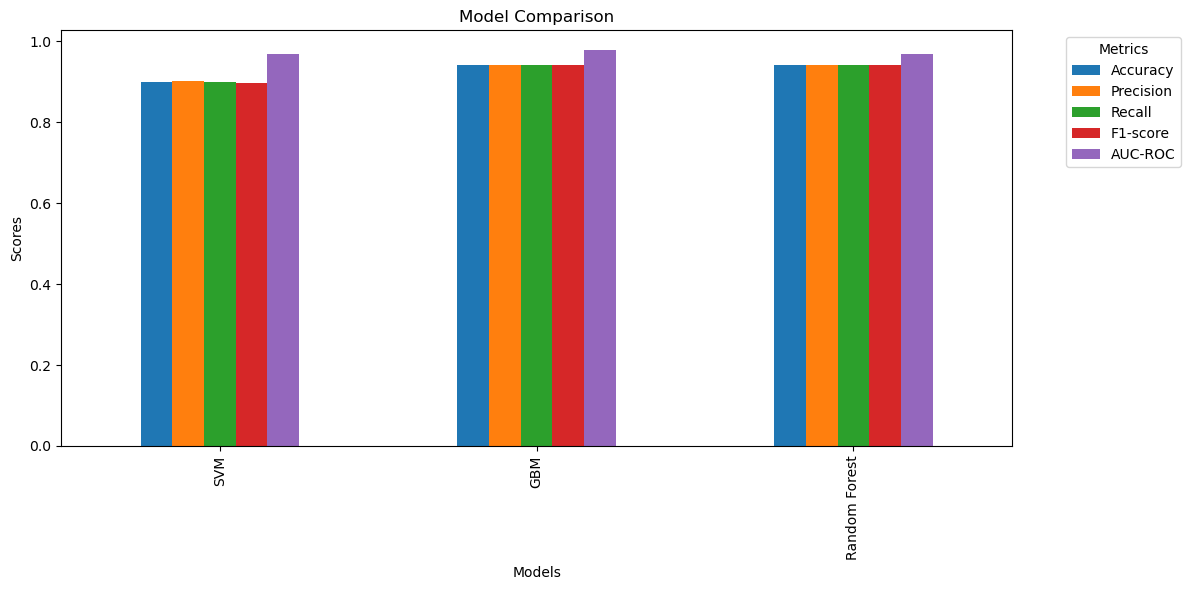

In [18]:
# Define the models
svm = SVC(random_state=42, probability=True)  # Set probability=True
gbm = GradientBoostingClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

# Define parameter distributions for RandomizedSearchCV
svm_params = {
    'C': uniform(0.1, 10),
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': uniform(0.01, 1)
}

gbm_params = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

rf_params = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Function to perform RandomizedSearchCV and return best model
def tune_model(model, params, X_train, y_train):
    rs_cv = RandomizedSearchCV(model, params, n_iter=50, cv=5, n_jobs=-1, random_state=42, scoring='roc_auc')
    rs_cv.fit(X_train, y_train)
    return rs_cv.best_estimator_

# Tune models
print("Tuning SVM...")
best_svm = tune_model(svm, svm_params, X_train_scaled, y_train)

print("Tuning GBM...")
best_gbm = tune_model(gbm, gbm_params, X_train_scaled, y_train)

print("Tuning Random Forest...")
best_rf = tune_model(rf, rf_params, X_train_scaled, y_train)

# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return accuracy, precision, recall, f1, auc_roc

# Evaluate models
models = {'SVM': best_svm, 'GBM': best_gbm, 'Random Forest': best_rf}
results = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    accuracy, precision, recall, f1, auc_roc = evaluate_model(model, X_test_scaled, y_test)
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC-ROC': auc_roc
    }
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

# Create a summary table
summary_df = pd.DataFrame(results).T
print("\nSummary Table:")
print(summary_df)

# Plot the results
plt.figure(figsize=(12, 6))
summary_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Comparison')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('model_comparison.png')
print("Model comparison plot saved as 'model_comparison.png'")

# Print best parameters for each model
print("\nBest Parameters:")
print("SVM:", best_svm.get_params())
print("GBM:", best_gbm.get_params())
print("Random Forest:", best_rf.get_params())


In [20]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from scipy.stats import randint, uniform

# Define the models
svm = SVC(random_state=42, probability=True)  # Set probability=True
gbm = GradientBoostingClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

# Define parameter distributions for RandomizedSearchCV
svm_params = {
    'C': uniform(0.1, 10),
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': uniform(0.01, 1)
}

gbm_params = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

rf_params = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Function to perform RandomizedSearchCV and return best model
def tune_model(model, params, X_train, y_train):
    rs_cv = RandomizedSearchCV(model, params, n_iter=50, cv=5, n_jobs=-1, random_state=42, scoring='roc_auc')
    rs_cv.fit(X_train, y_train)
    return rs_cv.best_estimator_

print("Models and parameters defined successfully.")

Models and parameters defined successfully.


In [22]:
# Tune models
print("Tuning SVM...")
best_svm = tune_model(svm, svm_params, X_train_scaled, y_train)

print("Tuning GBM...")
best_gbm = tune_model(gbm, gbm_params, X_train_scaled, y_train)

print("Tuning Random Forest...")
best_rf = tune_model(rf, rf_params, X_train_scaled, y_train)

print("Model tuning completed.")

Tuning SVM...
Tuning GBM...
Tuning Random Forest...


C:\Users\saket\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Model tuning completed.



Evaluating SVM...
SVM Results:
Accuracy: 0.8992
Precision: 0.9023
Recall: 0.8992
F1-score: 0.8984
AUC-ROC: 0.9700

Evaluating GBM...
GBM Results:
Accuracy: 0.9412
Precision: 0.9412
Recall: 0.9412
F1-score: 0.9411
AUC-ROC: 0.9786

Evaluating Random Forest...
Random Forest Results:
Accuracy: 0.9412
Precision: 0.9412
Recall: 0.9412
F1-score: 0.9411
AUC-ROC: 0.9691

Summary Table:
               Accuracy  Precision    Recall  F1-score   AUC-ROC
SVM            0.899160   0.902322  0.899160  0.898373  0.970036
GBM            0.941176   0.941202  0.941176  0.941122  0.978597
Random Forest  0.941176   0.941202  0.941176  0.941122  0.969109
Model comparison plot saved as 'model_comparison.png'

Best Parameters:
SVM: {'C': 7.390071680409873, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.7812703466859457, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001

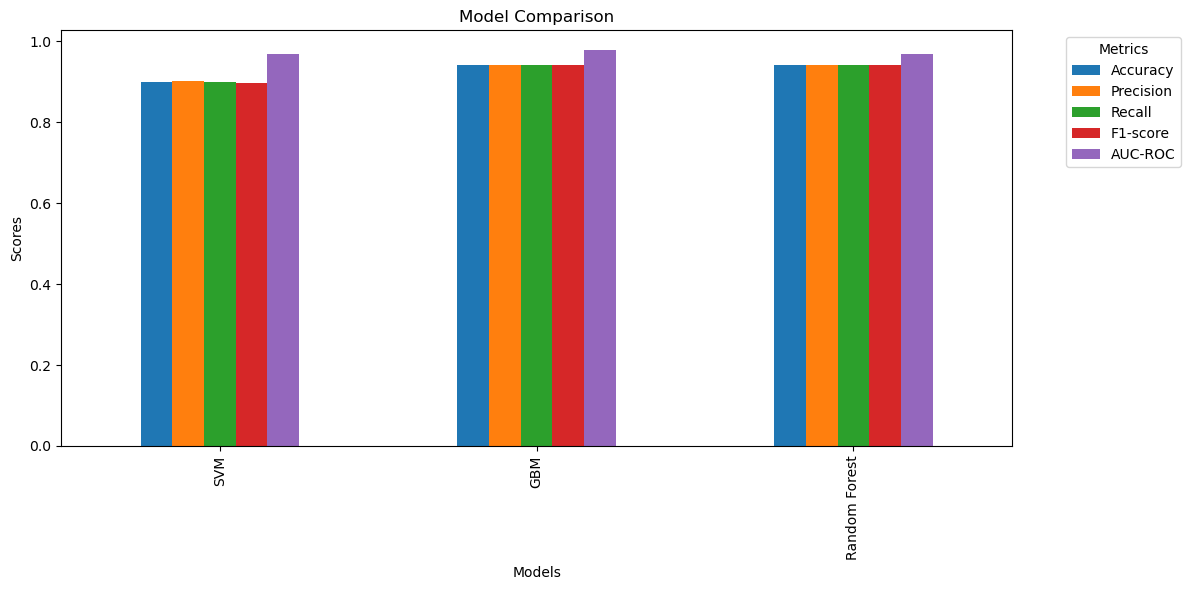

In [24]:
# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return accuracy, precision, recall, f1, auc_roc

# Evaluate models
models = {'SVM': best_svm, 'GBM': best_gbm, 'Random Forest': best_rf}
results = {}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    accuracy, precision, recall, f1, auc_roc = evaluate_model(model, X_test_scaled, y_test)
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC-ROC': auc_roc
    }
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

# Create a summary table
summary_df = pd.DataFrame(results).T
print("\nSummary Table:")
print(summary_df)

# Plot the results
plt.figure(figsize=(12, 6))
summary_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Comparison')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('model_comparison.png')
print("Model comparison plot saved as 'model_comparison.png'")

# Print best parameters for each model
print("\nBest Parameters:")
print("SVM:", best_svm.get_params())
print("GBM:", best_gbm.get_params())
print("Random Forest:", best_rf.get_params())